# Deploy Stable Diffusion on a SageMaker GPU Multi-Model Endpoint with LMI Containers and AiTemplate

**In this notebook we will host Stable Diffusion  SageMaker using LMI containers**

In this notebook, we explore how to host a large language model on SageMaker using the [Large Model Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-inference.html) container that is optimized for hosting large models using DJLServing. DJLServing is a high-performance universal model serving solution powered by the Deep Java Library (DJL) that is programming language agnostic. To learn more about DJL and DJLServing, you can refer to our recent [blog post](https://aws.amazon.com/blogs/machine-learning/deploy-large-models-on-amazon-sagemaker-using-djlserving-and-deepspeed-model-parallel-inference/).

Language models have recently exploded in both size and popularity. In 2018, BERT-large entered the scene and, with its 340M parameters and novel transformer architecture, set the standard on NLP task accuracy. Within just a few years, state-of-the-art NLP model size has grown by more than 500x with models such as OpenAI’s 175 billion parameter GPT-3 and similarly sized open source Bloom 176B raising the bar on NLP accuracy. This increase in the number of parameters is driven by the simple and empirically-demonstrated positive relationship between model size and accuracy: more is better. With easy access from models zoos such as Hugging Face and improved accuracy in NLP tasks such as classification and text generation, practitioners are increasingly reaching for these large models. However, deploying them can be a challenge because of their size.

In this notebook, we deploy the open source GPT-J Model which is comprised of 6B parameters on a single GPU. Along the way we will explore approaches that will allow us to scale to larger models with practically no code changes.

This notebook was tested on a `ml.g5.2xlarge` instance 


Model license: By using this model, please review and agree to the https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL

## Create a SageMaker Model for Deployment
As a first step, we'll import the relevant libraries and configure several global variables such as the hosting image that will be used nd the S3 location of our model artifacts

In [ ]:
%pip install -Uq sagemaker

In [ ]:
import sagemaker
from sagemaker.model import Model
from sagemaker import serializers, deserializers
from sagemaker import image_uris
import boto3
import os
import time
import json
import jinja2
from pathlib import Path

In [ ]:
import boto3
import sagemaker
from sagemaker import get_execution_role


import time
from PIL import Image
import numpy as np

# variables
s3_client = boto3.client("s3")
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [ ]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = (
    sagemaker.session.Session()
)  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
model_bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")

s3_code_prefix = "stablediffusion/aitemplate/code_sd_g5"  # folder within bucket where code artifact will go

s3_model_prefix = (
    f"s3://sagemaker-examples-files-prod-{region}/models/aitemplate_compiled/g5hw/"
)

jinja_env = (
    jinja2.Environment()
)  # jinja environment to generate model configuration templates

print(s3_model_prefix)

### Part 2 - Create the model.py file 

This file is the custom inference script for generating images. The model weights have been compiled for specific Hardware based on the below link

https://github.com/facebookincubator/AITemplate/blob/main/examples/05_stable_diffusion/scripts/demo.py

In [ ]:
!mkdir -p code_sd
!mkdir -p code_sd/src

In [ ]:
%%writefile code_sd/src/__init__.py

In [ ]:
# we plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
template = jinja_env.from_string(Path("jinja_templates/serving.template").open().read())
Path("code_sd/serving.properties").open("w").write(
    template.render(s3url=s3_model_prefix)
)
!pygmentize code_sd/serving.properties | cat -n

In [ ]:
%%writefile code_sd/src/pipeline_stable_diffusion_ait.py
#  Copyright (c) Meta Platforms, Inc. and affiliates.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
import inspect

import os
import warnings
from typing import List, Optional, Union

import torch
from aitemplate.compiler import Model

from diffusers import (
    AutoencoderKL,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)

from diffusers.pipelines.stable_diffusion import (
    StableDiffusionPipelineOutput,
    StableDiffusionSafetyChecker,
)

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import logging


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


class StableDiffusionAITPipeline(StableDiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion.
    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)
    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latens. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offsensive or harmful.
            Please, refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[
            DDIMScheduler,
            PNDMScheduler,
            LMSDiscreteScheduler,
            EulerDiscreteScheduler,
            EulerAncestralDiscreteScheduler,
            DPMSolverMultistepScheduler,
        ],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
        requires_safety_checker: bool = True,
    ):
        super().__init__(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
            requires_safety_checker=requires_safety_checker,
        )

        workdir = os.getenv("AIT_MODEL_PATH")
        logger.info(f"StableDiffusionAITPipeline::init:workdir={workdir}")

        self.clip_ait_exe = self.init_ait_module(
            model_name="CLIPTextModel", workdir=workdir
        )
        self.unet_ait_exe = self.init_ait_module(
            model_name="UNet2DConditionModel", workdir=workdir
        )
        self.vae_ait_exe = self.init_ait_module(
            model_name="AutoencoderKL", workdir=workdir
        )

    def init_ait_module(
        self,
        model_name,
        workdir,
    ):
        mod = Model(os.path.join(workdir, model_name, "test.so"))
        return mod

    def unet_inference(self, latent_model_input, timesteps, encoder_hidden_states):
        exe_module = self.unet_ait_exe
        timesteps_pt = timesteps.expand(latent_model_input.shape[0])
        inputs = {
            "input0": latent_model_input.permute((0, 2, 3, 1))
            .contiguous()
            .cuda()
            .half(),
            "input1": timesteps_pt.cuda().half(),
            "input2": encoder_hidden_states.cuda().half(),
        }
        ys = []
        num_outputs = len(exe_module.get_output_name_to_index_map())
        for i in range(num_outputs):
            shape = exe_module.get_output_maximum_shape(i)
            ys.append(torch.empty(shape).cuda().half())
        exe_module.run_with_tensors(inputs, ys, graph_mode=False)
        noise_pred = ys[0].permute((0, 3, 1, 2)).float()
        return noise_pred

    def clip_inference(self, input_ids, seqlen=64):
        exe_module = self.clip_ait_exe
        bs = input_ids.shape[0]
        position_ids = torch.arange(seqlen).expand((bs, -1)).cuda()
        inputs = {
            "input0": input_ids,
            "input1": position_ids,
        }
        ys = []
        num_outputs = len(exe_module.get_output_name_to_index_map())
        for i in range(num_outputs):
            shape = exe_module.get_output_maximum_shape(i)
            ys.append(torch.empty(shape).cuda().half())
        exe_module.run_with_tensors(inputs, ys, graph_mode=False)
        return ys[0].float()

    def vae_inference(self, vae_input):
        exe_module = self.vae_ait_exe
        inputs = [torch.permute(vae_input, (0, 2, 3, 1)).contiguous().cuda().half()]
        ys = []
        num_outputs = len(exe_module.get_output_name_to_index_map())
        for i in range(num_outputs):
            shape = exe_module.get_output_maximum_shape(i)
            ys.append(torch.empty(shape).cuda().half())
        exe_module.run_with_tensors(inputs, ys, graph_mode=False)
        vae_out = ys[0].permute((0, 3, 1, 2)).float()
        return vae_out

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = 512,
        width: Optional[int] = 512,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.
        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to 512):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to 512):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """

        if "torch_device" in kwargs:
            device = kwargs.pop("torch_device")
            warnings.warn(
                "`torch_device` is deprecated as an input argument to `__call__` and will be removed in v0.3.0."
                " Consider using `pipe.to(torch_device)` instead."
            )

            # Set device as before (to be removed in 0.3.0)
            if device is None:
                device = "cuda" if torch.cuda.is_available() else "cpu"
            self.to(device)

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(
                f"`prompt` has to be of type `str` or `list` but is {type(prompt)}"
            )

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(
                f"`height` and `width` have to be divisible by 8 but are {height} and {width}."
            )

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=64,  # self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.clip_inference(text_input.input_ids.to(self.device))

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input.input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )
            uncond_embeddings = self.clip_inference(
                uncond_input.input_ids.to(self.device)
            )

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        latents_device = "cpu" if self.device.type == "mps" else self.device
        latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)
        if latents is None:
            latents = torch.randn(
                latents_shape,
                generator=generator,
                device=latents_device,
            )
        else:
            if latents.shape != latents_shape:
                raise ValueError(
                    f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}"
                )
        latents = latents.to(self.device)

        # set timesteps
        accepts_offset = "offset" in set(
            inspect.signature(self.scheduler.set_timesteps).parameters.keys()
        )
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        latents = latents * self.scheduler.init_noise_sigma

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(
            inspect.signature(self.scheduler.step).parameters.keys()
        )
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta
            # check if the scheduler accepts generator
        accepts_generator = "generator" in set(
            inspect.signature(self.scheduler.step).parameters.keys()
        )
        if accepts_generator:
            extra_step_kwargs["generator"] = generator

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            if isinstance(self.scheduler, LMSDiscreteScheduler):
                sigma = self.scheduler.sigmas[i]
                # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            noise_pred = self.unet_inference(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            )

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                latents = self.scheduler.step(
                    noise_pred, i, latents, **extra_step_kwargs
                ).prev_sample
            else:
                latents = self.scheduler.step(
                    noise_pred, t, latents, **extra_step_kwargs
                ).prev_sample

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae_inference(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(
                self.numpy_to_pil(image), return_tensors="pt"
            ).to(self.device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values
            )
        else:
            has_nsfw_concept = None

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

In [ ]:
%%writefile code_sd/model.py
from djl_python import Input, Output
import deepspeed
import torch
import logging
import math
import os
import sys
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import logging

from io import BytesIO

import torch
import aitemplate

# from torch.utils.dlpack import to_dlpack, from_dlpack

# from aitemplate.testing.benchmark_pt import benchmark_torch_function
# from aitemplate.utils.import_path import import_parent
from diffusers import DPMSolverMultistepScheduler
from diffusers import (
    AutoencoderKL,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)

import logging


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)


model = None


def load_model(properties):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logger.info(f"Model:init:args={properties}:")
    logger.info(f"Model device={device}:")

    tensor_parallel = properties["tensor_parallel_degree"]
    model_dir = properties["model_dir"]
    if "model_id" in properties:
        model_dir = properties["model_id"]
    logging.info(f"Loading model in {model_dir}: was set in model_id:")
    sys.path.append(model_dir)

    for f in os.listdir(model_dir):
        logger.info(f" model_dir={model_dir}:: file={f}::")

    # from src import pipeline_stable_diffusion_ait
    from src.pipeline_stable_diffusion_ait import StableDiffusionAITPipeline

    os.environ[
        "AIT_MODEL_PATH"
    ] = f"{model_dir}/"  # -- this is needed to load the AIT model in the CLIPText etc
    # - check the notes for why this needs to be done
    pipe = StableDiffusionAITPipeline.from_pretrained(
        f"{model_dir}/diffusers-pipeline/stabilityai/stable-diffusion-v2",
        scheduler=EulerDiscreteScheduler.from_pretrained(  # scheduler/scheduler_config.json
            f"{model_dir}/diffusers-pipeline/stabilityai/stable-diffusion-v2",
            subfolder="scheduler",
        ),
        revision="fp16",
        torch_dtype=torch.float16,
    )
    pipe.to(device)

    logger.info(f" Pipe Model created successfully:")

    # pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    logger.info(f" Pipe Scheduler config: created successfully:")
    return pipe


def run_inference(model, inputs):
    logger.info(f"Prediction:request_list={inputs}:")

    input_text = inputs["prompt"]
    with torch.autocast("cuda"):
        image = model(input_text, 512, 512).images[0]

    # image.save("example_ait.png")
    buf = BytesIO()
    image.save(buf, format="PNG")
    byte_img = buf.getvalue()
    return byte_img
    # return Output().add(byte_img).add_property("content-type", "image/png")


def handle(inputs: Input):
    global model
    if not model:
        model = load_model(inputs.get_properties())

    if inputs.is_empty():
        # Model server makes an empty call to warmup the model on startup
        return None
    data = inputs.get_as_json()

    input_sentences = data["inputs"]

    byte_img = run_inference(model, input_sentences)
    # return Output().add_as_json(result)
    return Output().add(byte_img).add_property("content-type", "image/png")

There are a few options specified here. Lets go through them in turn<br>
1. `engine` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the [DJL Python Engine](https://github.com/deepjavalibrary/djl-serving/tree/master/engines/python)
2. `option.entryPoint` - specifies the entrypoint code that will be used to host the model. djl_python.huggingface refers to the `huggingface.py` module from [djl_python repo](https://github.com/deepjavalibrary/djl-serving/tree/master/engines/python/setup/djl_python).  
3. `option.s3url` - specifies the location of the model files. Alternativelly an `option.model_id` option can be used instead to specifiy a model from Hugging Face Hub (e.g. `EleutherAI/gpt-j-6B`) and the model will be automatically downloaded from the Hub. The s3url approach is recommended as it allows you to host the model artifact within your own environment and enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance 
4. `option.task` - This is specific to the `huggingface.py` inference handler and specifies for which task this model will be used
5. `option.device_map` - Enables layer-wise model partitioning through [Hugging Face Accelerate](https://huggingface.co/docs/accelerate/usage_guides/big_modeling#designing-a-device-map). With `option.device_map=auto`, Accelerate will determine where to put each **layer** to maximize the use of your fastest devices (GPUs) and offload the rest on the CPU, or even the hard drive if you don’t have enough GPU RAM (or CPU RAM). Even if the model is split across several devices, it will run as you would normally expect.
6. `option.load_in_8bit` - Quantizes the model weights to int8 thereby greatly reducing the memory footprint of the model from the initial FP32. See this [blog post](https://huggingface.co/blog/hf-bitsandbytes-integration) from Hugging Face for additional information 

For more information on the available options, please refer to the [SageMaker Large Model Inference Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-configuration.html)

Below example is mainly for how we can shard models using Model Parallelism, we can use Tensor Parallelisim as well. Like within Hugging Face Transformers to enable Large Language Model hosting these are exposed through the `device_map` and `load_in_8bit` parameters which enable sharding and shrinking of the model. The sharding approach taken here is layer wise as individual model layers are placed onto different GPU devices and data flows sequentially from the input to the final output layer as illustated below<br>
<img src="images/LayerShard.png" width="800"/>

Even though in this example the model will be running on a single GPU and will not be sharded, this parameter would automatically apply sharding as we scale to larger models on multi-GPU instances.

In [ ]:
%%writefile code_sd/requirements.txt
boto3
awscli
# git+https://github.com/facebookincubator/AITemplate@0.2

In [ ]:
!rm -rf `find -type d -name .ipynb_checkpoints`
!rm model.tar.gz
!tar czvf model.tar.gz code_sd

### Upload the Tar file to S3 for Creation of End points

In [ ]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

In [ ]:
print(f"S3 Model Prefix where the model files are -- > {s3_model_prefix}")
print(f"S3 Model Bucket is -- > {model_bucket}")

In [ ]:
# inference_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/djl-ds:latest"
inference_image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.0-cu117"
print(f"Image going to be used is ---- > {inference_image_uri}")

### Creating end point in SageMaker
<li>First create a Model
<li>Second Create the endpoint config
<li>Third Create the endpoint to host the model

In [ ]:
s3_code_artifact

In [ ]:
from sagemaker.utils import name_from_base

model_name = name_from_base(f"sd-aij-ds-g5xl")
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={"Image": inference_image_uri, "ModelDataUrl": s3_code_artifact},
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

In [ ]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g5.2xlarge",  # "ml.p3.2xlarge", #"ml.g4dn.2xlarge", #"ml.g5.4xlarge", #"ml.g4dn.2xlarge", #"ml.g5.12xlarge", #"ml.g5.xlarge",
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": 2400,
            # "VolumeSizeInGB": 200
        },
    ],
)
endpoint_config_response

Create a SageMaker endpoint configuration.

In [ ]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Create the endpoint, and wait for it to be up and running.

In [ ]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

#### Invoke model

Let's run an example with a basic text generation prompt `Smiling Person`

this will create a 512 x 512 resolution picture

In [ ]:
%%time
import json

response_model = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=json.dumps(
        {
            "inputs": {"prompt": "Mountains Landscape"},  # prompts,
        }
    ),
    ContentType="application/json",
)

response_model

In [61]:
resp = response_model["Body"].read()

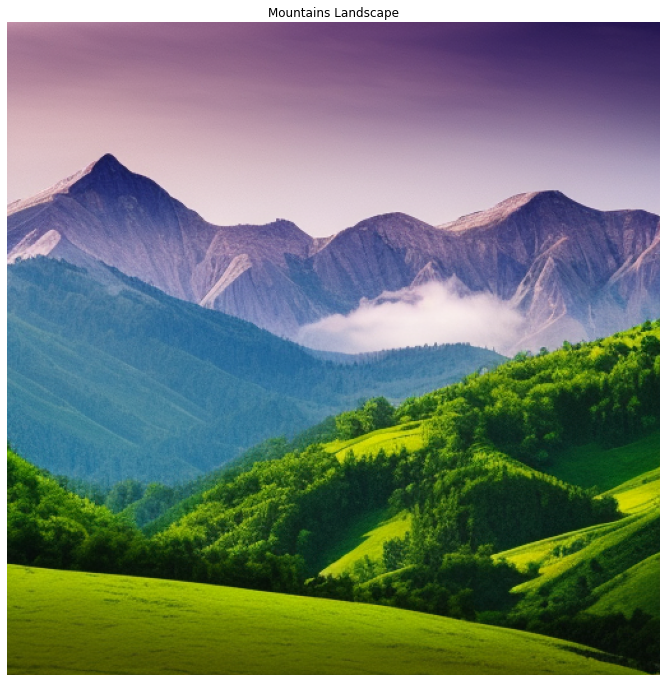

In [62]:
from PIL import Image
import numpy as np
import io
import base64
import matplotlib.pyplot as plt


def decode_image(img):
    buff = io.BytesIO(img)
    image = Image.open(buff)
    return image


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()


display_img_and_prompt(decode_image(resp), "Mountains Landscape")

In [ ]:
# from PIL import Image
# import numpy as np
# import io

# !export DISPLAY=:0.0
# img_res = io.BytesIO(response_model["Body"].read())
# Image.open(img_res).show()

#### P95 numbers

In [ ]:
import numpy as np

results = []
for i in range(0, 10):
    start = time.time()
    prompts = ["Mountains Landscape"]
    response_model = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": {"prompt": "Mountains Landscape"},  # prompts,
            }
        ),
        ContentType="application/json",
    )
    results.append((time.time() - start) * 1000)

print("\nPredictions for model latency: \n")
print("\nP95: " + str(np.percentile(results, 95)) + " ms\n")
print("P90: " + str(np.percentile(results, 90)) + " ms\n")
print("Average: " + str(np.average(results)) + " ms\n")

----
----
### Part 7 - Clean up <a name="cleanup"></a>

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=model_name)